# RPS Performance Analysis

This notebook analyzes the performance results from the Rashomon Partition Set (RPS) algorithm simulation study. 

The simulation varies:
- **M**: Number of features (3, 4, 5)
- **R**: Factor levels per feature (3, 4, 5) 
- **H**: Maximum number of pools (multipliers: 1.0, 1.5, 2.0)
- **ε (epsilon)**: Rashomon threshold (0.5, 1.0, 2.0, 4.0)

For each parameter combination, we analyze:
- **Runtime performance** of the RPS algorithm
- **Accuracy** in terms of pool mean errors
- **Coverage** comparing RPS partitions found vs. total possible partitions

## 1. Import Required Libraries

In [72]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats
# import warnings

# warnings.filterwarnings('ignore')

# # Set plotting style
# plt.style.use('default')
# sns.set_palette("husl")
# plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['font.size'] = 12


## Setup 1

In [58]:
# Load the simulation results
results_dir = "../Results/timed_sims/setup_1"

fnames = os.listdir(results_dir)

df = None
for fname in fnames:
    if fname.endswith(".csv"):
        file_path = os.path.join(results_dir, fname)
        temp_df = pd.read_csv(file_path)
        if df is None:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], ignore_index=True)
        print(f"✅ Loaded {fname} with {len(temp_df)} rows")


df["RPS_frac"] = df["num_rps_partitions"] / df["total_partitions"]

df.head()

✅ Loaded rps_performance_results_4_4_setup_1.csv with 130 rows
✅ Loaded rps_performance_results_3_4_setup_1.csv with 130 rows


,M,R_val,epsilon,seed,n_per_policy,all_partitions_time,rps_time,total_partitions,num_rps_partitions,map_q_value,map_posterior_prob,norm_constant,rps_norm_constant,theta_used,found_true_partition,rps_posterior_beta_error,full_posterior_beta_error,RPS_frac
0,4,4,0.01,0,30,0.721313,2.344078,4096,2,2.14692,0.00902,12.954478,0.231970,2.168389,0,9.044051,7.584417,0.000488
1,4,4,0.05,0,30,0.721313,2.374645,4096,12,2.14692,0.00902,12.954478,1.305875,2.254266,0,8.652294,7.584417,0.002930
2,4,4,0.10,0,30,0.721313,2.526453,4096,24,2.14692,0.00902,12.954478,2.493318,2.361612,0,8.628271,7.584417,0.005859
3,4,4,0.15,0,30,0.721313,2.470802,4096,48,2.14692,0.00902,12.954478,4.622945,2.468958,0,8.413214,7.584417,0.011719
4,4,4,0.20,0,30,0.721313,2.442182,4096,64,2.14692,0.00902,12.954478,5.892863,2.576304,0,8.290983,7.584417,0.015625


In [59]:
df_summary = df.groupby(["M", "epsilon", "R_val"]).agg(
    mean_time=("rps_time", "mean"),
    std_time=("rps_time", "std"),
    mean_frac=("RPS_frac", "mean")
)

df_summary = df_summary.reset_index()

df_m3 = df_summary[df_summary["M"] == 3]
print(df_m3.head())

df_m4 = df_summary[df_summary["M"] == 4]
print(df_m4.head())

   M  epsilon  R_val  mean_time  std_time  mean_frac
0  3     0.01      4   0.212937  0.003403   0.001953
1  3     0.05      4   0.216917  0.013475   0.001953
2  3     0.10      4   0.214301  0.004154   0.002344
3  3     0.15      4   0.219290  0.003278   0.007422
4  3     0.20      4   0.223405  0.002919   0.013086
    M  epsilon  R_val  mean_time  std_time  mean_frac
13  4     0.01      4   2.372712  0.203485   0.000439
14  4     0.05      4   2.429296  0.249846   0.002393
15  4     0.10      4   2.446412  0.190294   0.005713
16  4     0.15      4   2.535090  0.255481   0.011499
17  4     0.20      4   2.590260  0.318574   0.015356


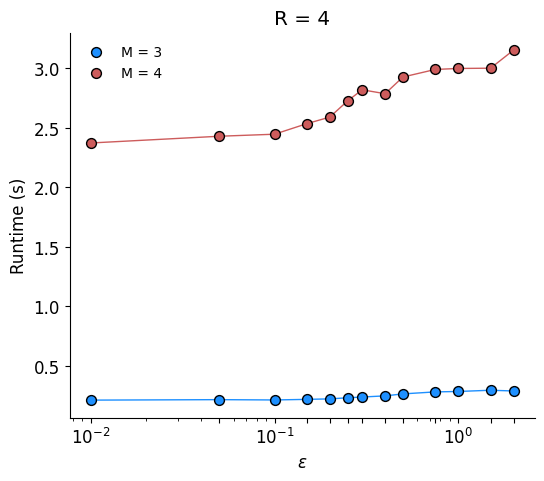

In [71]:
# Plot rps_mean_time against R_val

plt.figure(figsize=(6, 5))


# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.plot(df_m3["epsilon"], df_m3["mean_time"], color="dodgerblue", linewidth=1, zorder=1)
plt.scatter(df_m3["epsilon"], df_m3["mean_time"], s=50,
            color="dodgerblue", edgecolor="black", zorder=2,
         label="M = 3")

plt.plot(df_m4["epsilon"], df_m4["mean_time"], color="indianred", linewidth=1, zorder=1)
plt.scatter(df_m4["epsilon"], df_m4["mean_time"], s=50,
            color="indianred", edgecolor="black", zorder=2,
         label="M = 4")

plt.xscale("log")
plt.xticks(df_m3["epsilon"])

plt.xlabel(r"$\epsilon$")
plt.ylabel("Runtime (s)")
plt.title("R = 4")

# Add legend
plt.legend(loc="upper left", fontsize=10, frameon=False)

plt.show()

### Error plots

In [81]:
# Load the simulation results
results_dir = "../Results/timed_sims/setup_1"

fnames = os.listdir(results_dir)

results_m3 = []
results_m4 = []
for fname in fnames:
    if fname.endswith(".pkl"):
        file_path = os.path.join(results_dir, fname)
        with open(file_path, "rb") as f:
            temp_results = pickle.load(f)
            if "M3" in fname:
                results_m3.append(temp_results)
            elif "M4" in fname:
                results_m4.append(temp_results)

print(f"✅ Loaded {len(results_m3)} results from {len(fnames)} files for M = 3")
print(f"✅ Loaded {len(results_m4)} results from {len(fnames)} files for M = 4")

✅ Loaded 10 results from 22 files for M = 3
✅ Loaded 10 results from 22 files for M = 4


In [ ]:
results_m3[0].keys()

dict_keys(['all_partitions_set', 'all_q_values', 'all_betas', 'all_sigmas', 'norm_constant', 'map_idx', 'map_q_value', 'map_posterior_prob', 'full_posterior_beta', 'policy_means', 'all_partitions_time', 'reg'])

In [112]:
def error_results(results):
    errors = None
    for result in results:
        q = result["all_q_values"]
        q = np.sort(q)
        epsilon = q / q[0] - 1

        num_partitions = q.shape[0]
        posterior = np.exp(-q)
        posterior /= np.sum(posterior)

        rps_size = np.linspace(1, num_partitions, num_partitions)
        lambda_est = posterior * rps_size

        error = 1 / lambda_est - lambda_est

        df_temp = pd.DataFrame({
            "epsilon": epsilon,
            "rps_size": rps_size,
            "posterior": posterior,
            "lambda_est": lambda_est,
            "error": error,
            "theta": posterior
        })

        if errors is None:
            errors = df_temp
        else:
            errors = pd.concat([errors, df_temp], ignore_index=True)
    return errors

errors_m3 = error_results(results_m3)
print(errors_m3.head())

errors_m4 = error_results(results_m4)
print(errors_m4.head())

    epsilon  rps_size  posterior  lambda_est      error     theta
0  0.000000       1.0   0.030971    0.030971  32.257015  0.030971
1  0.129646       2.0   0.025401    0.050802  19.633330  0.025401
2  0.129779       3.0   0.025396    0.076188  13.049225  0.025396
3  0.142936       4.0   0.024890    0.099561   9.944574  0.024890
4  0.202356       5.0   0.022728    0.113641   8.686036  0.022728
    epsilon  rps_size  posterior  lambda_est       error     theta
0  0.000000       1.0   0.009009    0.009009  110.986126  0.009009
1  0.012243       2.0   0.008761    0.017523   57.050784  0.008761
2  0.014546       3.0   0.008716    0.026147   38.219645  0.008716
3  0.024663       4.0   0.008517    0.034067   29.319516  0.008517
4  0.038865       5.0   0.008246    0.041228   24.214363  0.008246


In [113]:
def errors_summary(errors):
    summary = errors.groupby("rps_size").agg(
        mean_epsilon=("epsilon", "mean"),
        mean_theta=("theta", "mean"),
        mean_error=("error", "mean"),
        std_error=("error", "std")
    ).reset_index()
    return summary

summary_m3 = errors_summary(errors_m3)
print(summary_m3.head())

summary_m4 = errors_summary(errors_m4)
print(summary_m4.head())

   rps_size  mean_epsilon  mean_theta  mean_error  std_error
0       1.0      0.000000    0.029856   33.511984   1.322092
1       2.0      0.116313    0.025125   19.860760   0.493726
2       3.0      0.133638    0.024515   13.542312   0.534048
3       4.0      0.147335    0.023998   10.326952   0.249318
4       5.0      0.178930    0.022900    8.621043   0.139984
   rps_size  mean_epsilon  mean_theta  mean_error  std_error
0       1.0      0.000000    0.009082  110.104159   1.058194
1       2.0      0.008495    0.008917   56.057111   0.414682
2       3.0      0.014365    0.008805   37.833493   0.257545
3       4.0      0.027552    0.008558   29.180157   0.287411
4       5.0      0.036921    0.008386   23.810595   0.279304


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


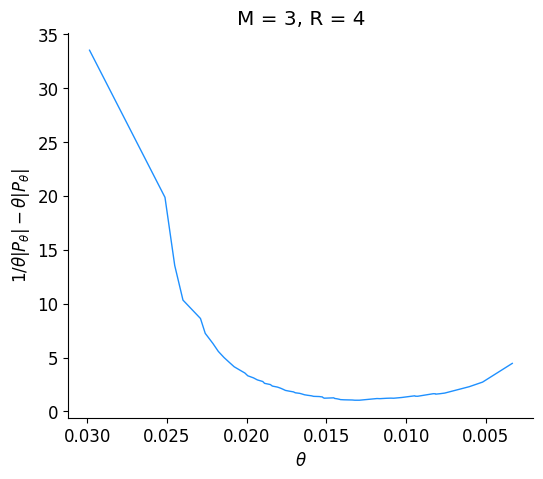

In [124]:
# Plot rps_mean_time against R_val

plt.figure(figsize=(6, 5))


# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.plot(summary_m3["mean_theta"], summary_m3["mean_error"], color="dodgerblue", linewidth=1, zorder=1)

# Reverse x-axis 
plt.gca().invert_xaxis()

plt.xlabel(r"$\theta$")
plt.ylabel(r"$1 / \theta |P_{\theta}| - \theta |P_{\theta}|$")
plt.title("M = 3, R = 4")

# Add legend
plt.legend(loc="upper left", fontsize=10, frameon=False)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


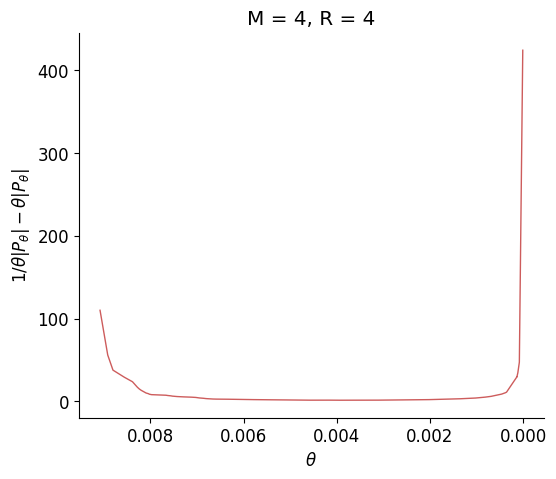

In [123]:
# Plot rps_mean_time against R_val

plt.figure(figsize=(6, 5))


# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# plt.plot(summary_m4["mean_theta"], summary_m4["mean_error"], color="indianred", linewidth=1, zorder=1)
plt.plot(summary_m4["mean_theta"], summary_m4["mean_error"], color="indianred", linewidth=1, zorder=1)

# Reverse x-axis 
plt.gca().invert_xaxis()

plt.xlabel(r"$\theta$")
plt.ylabel(r"$1 / \theta |P_{\theta}| - \theta |P_{\theta}|$")
plt.title("M = 4, R = 4")

# Add legend
plt.legend(loc="upper left", fontsize=10, frameon=False)

plt.show()

## Setup 2

In [44]:
# Load the simulation results
results_dir = "../Results/timed_sims/setup_2"

fnames = os.listdir(results_dir)

df = None
for fname in fnames:
    if fname.endswith(".csv"):
        file_path = os.path.join(results_dir, fname)
        temp_df = pd.read_csv(file_path)
        if df is None:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], ignore_index=True)
        print(f"✅ Loaded {fname} with {len(temp_df)} rows")


df["RPS_frac"] = df["num_rps_partitions"] / df["total_partitions"]

df.head()

✅ Loaded rps_performance_results_3_8_setup_2.csv with 10 rows
✅ Loaded rps_performance_results_3_4_setup_2.csv with 10 rows
✅ Loaded rps_performance_results_3_7_setup_2.csv with 10 rows
✅ Loaded rps_performance_results_3_5_setup_2.csv with 10 rows
✅ Loaded rps_performance_results_3_6_setup_2.csv with 10 rows


,M,R_val,epsilon,seed,n_per_policy,all_partitions_time,rps_time,total_partitions,num_rps_partitions,map_q_value,map_posterior_prob,norm_constant,rps_norm_constant,theta_used,found_true_partition,rps_posterior_beta_error,full_posterior_beta_error,RPS_frac
0,3,8,0.01,0,30,NaN,7217.514640,2097152,17670,3.673129,NaN,NaN,765.444640,3.709861,1,14.987579,NaN,0.008426
1,3,8,0.01,1,30,NaN,6893.647254,2097152,17840,3.692211,NaN,NaN,768.187964,3.729134,1,15.076641,NaN,0.008507
2,3,8,0.01,2,30,NaN,6818.676449,2097152,17420,3.698361,NaN,NaN,729.677130,3.735345,1,15.004870,NaN,0.008307
3,3,8,0.01,3,30,NaN,6738.298382,2097152,17703,3.687901,NaN,NaN,758.913962,3.724780,1,15.014146,NaN,0.008441
4,3,8,0.01,4,30,NaN,6748.116896,2097152,17737,3.686775,NaN,NaN,763.899016,3.723643,1,15.068315,NaN,0.008458


In [45]:
df_summary = df.groupby(["M", "epsilon", "R_val"]).agg(
    mean_time=("rps_time", "mean"),
    std_time=("rps_time", "std"),
    mean_frac=("RPS_frac", "mean")
)

df_summary = df_summary.reset_index()

df_summary.head()

,M,epsilon,R_val,mean_time,std_time,mean_frac
0,3,0.01,4,0.163349,0.003910,0.017383
1,3,0.01,5,2.414450,0.088080,0.000488
2,3,0.01,6,37.319845,1.353425,0.005649
3,3,0.01,7,635.702722,70.177434,0.045068
4,3,0.01,8,6605.096419,337.501463,0.008436


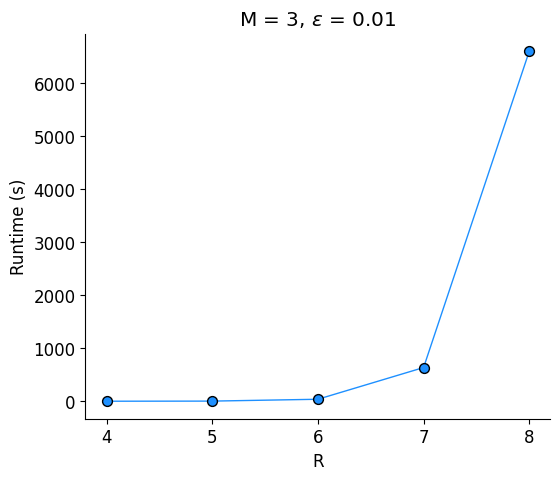

In [43]:
# Plot rps_mean_time against R_val

plt.figure(figsize=(6, 5))


# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.plot(df_summary["R_val"], df_summary["mean_time"], color="dodgerblue", linewidth=1, zorder=1)
plt.scatter(df_summary["R_val"], df_summary["mean_time"], s=50,
            color="dodgerblue", edgecolor="black", zorder=2)

plt.xticks(df_summary["R_val"])

plt.xlabel("R")
plt.ylabel("Runtime (s)")
plt.title(r"M = 3, $\epsilon$ = 0.01")

plt.show()

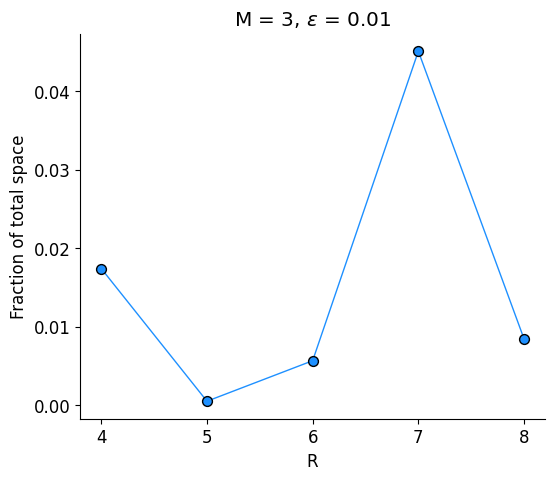

In [46]:
# Plot rps_mean_time against R_val

plt.figure(figsize=(6, 5))


# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.plot(df_summary["R_val"], df_summary["mean_frac"], color="dodgerblue", linewidth=1, zorder=1)
plt.scatter(df_summary["R_val"], df_summary["mean_frac"], s=50,
            color="dodgerblue", edgecolor="black", zorder=2)

plt.xticks(df_summary["R_val"])

plt.xlabel("R")
plt.ylabel("Fraction of total space")
plt.title(r"M = 3, $\epsilon$ = 0.01")

plt.show()

## Setup 3

In [47]:
# Load the simulation results
results_dir = "../Results/timed_sims/setup_3"

fnames = os.listdir(results_dir)

df = None
for fname in fnames:
    if fname.endswith(".csv"):
        file_path = os.path.join(results_dir, fname)
        temp_df = pd.read_csv(file_path)
        if df is None:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], ignore_index=True)
        print(f"✅ Loaded {fname} with {len(temp_df)} rows")


df["RPS_frac"] = df["num_rps_partitions"] / df["total_partitions"]

df.head()

✅ Loaded rps_performance_results_4_4_setup_3.csv with 10 rows
✅ Loaded rps_performance_results_3_4_setup_3.csv with 10 rows
✅ Loaded rps_performance_results_6_4_setup_3.csv with 10 rows
✅ Loaded rps_performance_results_5_4_setup_3.csv with 10 rows


,M,R_val,epsilon,seed,n_per_policy,all_partitions_time,rps_time,total_partitions,num_rps_partitions,map_q_value,map_posterior_prob,norm_constant,rps_norm_constant,theta_used,found_true_partition,rps_posterior_beta_error,full_posterior_beta_error,RPS_frac
0,4,4,0.01,0,30,NaN,1.998042,4096,163,3.344252,NaN,NaN,11.355616,3.377695,1,7.839325,NaN,0.039795
1,4,4,0.01,1,30,NaN,1.851931,4096,163,3.399652,NaN,NaN,10.817549,3.433649,1,7.833604,NaN,0.039795
2,4,4,0.01,2,30,NaN,1.862751,4096,166,3.381641,NaN,NaN,11.478049,3.415458,1,7.860923,NaN,0.040527
3,4,4,0.01,3,30,NaN,1.922495,4096,163,3.396016,NaN,NaN,10.692964,3.429976,1,7.819222,NaN,0.039795
4,4,4,0.01,4,30,NaN,1.871149,4096,162,3.324689,NaN,NaN,11.624107,3.357936,1,7.832864,NaN,0.039551


In [48]:
df_summary = df.groupby(["M", "epsilon", "R_val"]).agg(
    mean_time=("rps_time", "mean"),
    std_time=("rps_time", "std"),
    mean_frac=("RPS_frac", "mean")
)

df_summary = df_summary.reset_index()

df_summary.head()

,M,epsilon,R_val,mean_time,std_time,mean_frac
0,3,0.01,4,0.169518,0.005773,0.017383
1,4,0.01,4,1.978672,0.126095,0.040063
2,5,0.01,4,27.945956,1.216192,0.009157
3,6,0.01,4,467.738562,54.224442,0.000006


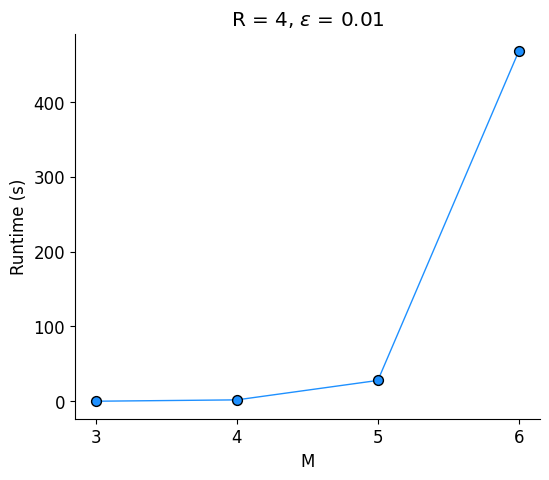

In [50]:
# Plot rps_mean_time against R_val

plt.figure(figsize=(6, 5))


# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.plot(df_summary["M"], df_summary["mean_time"], color="dodgerblue", linewidth=1, zorder=1)
plt.scatter(df_summary["M"], df_summary["mean_time"], s=50,
            color="dodgerblue", edgecolor="black", zorder=2)

plt.xticks(df_summary["M"])

plt.xlabel("M")
plt.ylabel("Runtime (s)")
plt.title(r"R = 4, $\epsilon$ = 0.01")

plt.show()

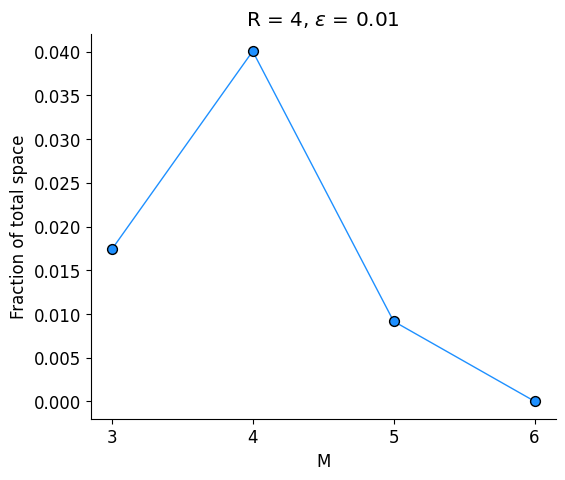

In [51]:
# Plot rps_mean_time against R_val

plt.figure(figsize=(6, 5))


# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.plot(df_summary["M"], df_summary["mean_frac"], color="dodgerblue", linewidth=1, zorder=1)
plt.scatter(df_summary["M"], df_summary["mean_frac"], s=50,
            color="dodgerblue", edgecolor="black", zorder=2)

plt.xticks(df_summary["M"])

plt.xlabel("M")
plt.ylabel("Fraction of total space")
plt.title(r"R = 4, $\epsilon$ = 0.01")

plt.show()